# Insider Threat Detection in Military and Defense Organizations Using Behavioral Data Analysis

**Abstract (200 words):**

This data analysis project, “Insider Threat Detection in Military and Defense Organizations Using Behavioral Data Analysis”, focuses on identifying potential internal security threats by analyzing user behavior, system access logs, and communication patterns. In high-security environments like the military, insider threats—whether intentional data leaks, unauthorized access, or sabotage—pose a significant risk. This project aims to uncover such threats using a data-driven, unsupervised machine learning approach.

The analysis begins with collecting and preprocessing structured logs that capture employee activity: login/logout times, file access records, privilege escalations, and email metadata. Behavioral baselines are then established for each user. Unsupervised learning techniques such as clustering and anomaly detection (e.g., Isolation Forest, DBSCAN, Local Outlier Factor) are applied to flag deviations from typical usage patterns, indicating possible insider threats.

The project uses Python-based tools like pandas, scikit-learn, plotly and dash to clean, model, and visualize the data. Key outcomes include ranked anomaly lists, visual explanations of unusual behavior, and an interactive dashboard for analysts to explore suspicious users. The notebook documents data cleaning steps (including handling missing values) to match professional EDA standards used in industry and academic reports.


In [13]:

# To install required packages
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly dash nbformat shap
print('Installed required packages')

Installed required packages


In [14]:

# Generating synthetic dataset: 3500 rows, 10% anomalies, ~8% Null records
import random, pandas as pd, numpy as np
from datetime import datetime, timedelta

random.seed(42); np.random.seed(42)

def gen_users(n_users=200):
    return [f"user{idx+1:03d}" for idx in range(n_users)]

def generate_behavior_rows(n_rows=3500, anomaly_frac=0.10, nan_frac=0.08):
    users = gen_users(200)
    rows = []
    for i in range(n_rows):
        user = random.choice(users)
        role = random.choice(['engineer','admin','ops','analyst','contractor'])
        logins = max(1, int(np.random.poisson(2)))
        failed_logins = max(0, int(np.random.binomial(1, 0.02)))
        files_accessed = max(0, int(np.random.poisson(5)))
        emails_sent = max(0, int(np.random.poisson(2)))
        privileged_commands = 1 if (role=='admin' and random.random() < 0.15) else 0
        external_device_use = 1 if random.random() < 0.02 else 0
        websites_visited = max(0, int(np.random.poisson(10)))
        off_hours_activity = 1 if random.random() < 0.05 else 0
        date = (datetime(2025,8,1) + timedelta(days=random.randint(0,89))).date().isoformat()
        rows.append({
            'user': user, 'role': role, 'date': date,
            'logins': logins, 'failed_logins': failed_logins,
            'files_accessed': files_accessed, 'emails_sent': emails_sent,
            'privileged_commands': privileged_commands, 'external_device_use': external_device_use,
            'websites_visited': websites_visited, 'off_hours_activity': off_hours_activity
        })
    df = pd.DataFrame(rows)
    # inject anomalies in our generated file
    anomaly_count = int(len(df) * anomaly_frac)
    idxs = df.sample(n=anomaly_count, random_state=1).index.tolist()
    anomaly_map = {}
    for idx in idxs:
        typ = random.choice(['mass_file_access','privilege_escalation','late_night','exfil_email','failed_login_spike'])
        anomaly_map[int(idx)] = typ
        if typ == 'mass_file_access':
            df.at[idx,'files_accessed'] += int(np.random.poisson(200)) + 50
        elif typ == 'privilege_escalation':
            df.at[idx,'privileged_commands'] = 1
            df.at[idx,'failed_logins'] += int(np.random.poisson(3))
        elif typ == 'late_night':
            df.at[idx,'off_hours_activity'] = 1
            df.at[idx,'logins'] += int(np.random.poisson(3))
        elif typ == 'exfil_email':
            df.at[idx,'emails_sent'] += int(np.random.poisson(30)) + 10
            df.at[idx,'files_accessed'] += int(np.random.poisson(120))
        elif typ == 'failed_login_spike':
            df.at[idx,'failed_logins'] += int(np.random.poisson(10)) + 2
    # inject Null values (across selected cols)
    n_nans = int(len(df) * nan_frac)
    cols_for_nan = ['failed_logins','files_accessed','emails_sent','websites_visited','role']
    nan_positions = []
    for _ in range(n_nans):
        i = random.randint(0, len(df)-1)
        c = random.choice(cols_for_nan)
        df.at[i, c] = np.nan
        nan_positions.append((int(i), c))
    out_path = '/content/raw_logs_v5.csv'
    df.to_csv(out_path, index=False)
    print(f'Generated {out_path} with {len(df)} rows, anomalies injected: {anomaly_count}, NaNs injected: {len(nan_positions)}')
    return df, anomaly_map, nan_positions

df_raw, anomaly_map, nan_positions = generate_behavior_rows()
df_raw.head()

Generated /content/raw_logs_v5.csv with 3500 rows, anomalies injected: 350, NaNs injected: 280


,user,role,date,logins,failed_logins,files_accessed,emails_sent,privileged_commands,external_device_use,websites_visited,off_hours_activity
0,user164,engineer,2025-08-29,4,0.0,4.0,3.0,0,0,7.0,0
1,user036,engineer,2025-08-12,2,0.0,4.0,1.0,0,0,11.0,0
2,user152,analyst,2025-08-30,1,0.0,6.0,0.0,0,0,10.0,0
3,user130,contractor,2025-10-23,3,0.0,283.0,1.0,0,0,8.0,0
4,user180,contractor,2025-09-05,2,0.0,3.0,3.0,0,0,13.0,0


In [15]:

# EDA: missing values, distributions, sample anomalies
import pandas as pd, numpy as np
df = pd.read_csv('/content/raw_logs_v5.csv')
print('Shape:', df.shape)
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nMissing percent per column:')
print((df.isnull().mean()*100).round(2))

print('\nSample of injected anomalies (first 10 indices):')
sample_idxs = list(sorted(list(anomaly_map.keys())[:10]))
display(df.loc[sample_idxs])

Shape: (3500, 11)

Missing values per column:
user                    0
role                   55
date                    0
logins                  0
failed_logins          63
files_accessed         64
emails_sent            49
privileged_commands     0
external_device_use     0
websites_visited       46
off_hours_activity      0
dtype: int64

Missing percent per column:
user                   0.00
role                   1.57
date                   0.00
logins                 0.00
failed_logins          1.80
files_accessed         1.83
emails_sent            1.40
privileged_commands    0.00
external_device_use    0.00
websites_visited       1.31
off_hours_activity     0.00
dtype: float64

Sample of injected anomalies (first 10 indices):


,user,role,date,logins,failed_logins,files_accessed,emails_sent,privileged_commands,external_device_use,websites_visited,off_hours_activity
330,user089,admin,2025-09-12,2,3.0,4.0,2.0,1,0,11.0,0
975,user046,analyst,2025-10-20,1,0.0,215.0,0.0,0,0,6.0,0
1263,user086,engineer,2025-08-23,1,0.0,248.0,3.0,0,0,7.0,0
1322,user136,analyst,2025-08-13,3,0.0,236.0,1.0,0,0,16.0,0
1533,user083,admin,2025-10-01,1,0.0,134.0,43.0,1,0,10.0,0
2508,user180,analyst,2025-09-06,3,12.0,7.0,1.0,0,0,9.0,0
3085,user045,analyst,2025-08-10,1,5.0,4.0,1.0,1,0,9.0,0
3123,user024,contractor,2025-09-04,2,0.0,NaN,2.0,0,0,7.0,0
3228,user065,analyst,2025-09-12,2,12.0,2.0,1.0,0,0,8.0,0
3308,user192,analyst,2025-08-15,3,NaN,7.0,0.0,1,0,5.0,0


In [16]:

# Cleaning & imputation
import pandas as pd
df = pd.read_csv('/content/raw_logs_v5.csv')

# To Drop columns with >35% nulls
drop_cols = df.columns[df.isnull().mean()*100 > 35].tolist()
print('Columns with >35% nulls (will drop):', drop_cols)
if drop_cols:
    df = df.drop(columns=drop_cols)

# Numeric imputation - median
num_cols = ['logins','failed_logins','files_accessed','emails_sent','privileged_commands','external_device_use','websites_visited','off_hours_activity']
for c in num_cols:
    missing = int(df[c].isnull().sum())
    if missing > 0:
        med = df[c].median()
        mean = df[c].mean()
        print(f'Imputing {missing} missing in {c} with median={med} (mean={mean:.2f})')
        df[c] = df[c].fillna(med)

# Categorical imputation for 'role'
if 'role' in df.columns:
    miss = int(df['role'].isnull().sum())
    if miss > 0:
        mode = df['role'].mode().iloc[0] if not df['role'].mode().empty else 'Unknown'
        print(f'Imputing {miss} missing in role with mode={mode}')
        df['role'] = df['role'].fillna(mode)

print('\nAfter imputation missing counts:')
print(df.isnull().sum())

df.to_csv('/content/cleaned_logs_v5.csv', index=False)
print('Saved /content/cleaned_logs_v5.csv')

Columns with >35% nulls (will drop): []
Imputing 63 missing in failed_logins with median=0.0 (mean=0.39)
Imputing 64 missing in files_accessed with median=5.0 (mean=11.63)
Imputing 49 missing in emails_sent with median=2.0 (mean=2.74)
Imputing 46 missing in websites_visited with median=10.0 (mean=9.98)
Imputing 55 missing in role with mode=admin

After imputation missing counts:
user                   0
role                   0
date                   0
logins                 0
failed_logins          0
files_accessed         0
emails_sent            0
privileged_commands    0
external_device_use    0
websites_visited       0
off_hours_activity     0
dtype: int64
Saved /content/cleaned_logs_v5.csv


In [17]:

# Feature engineering & types
import pandas as pd
df = pd.read_csv('/content/cleaned_logs_v5.csv')
df['activity_score'] = df['files_accessed'] + df['emails_sent']*2 + df['websites_visited']*0.5 + df['logins']*1.5 + df['failed_logins']*2
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.day_name().str.slice(0,3)
for c in ['logins','failed_logins','files_accessed','emails_sent','privileged_commands','external_device_use','websites_visited','off_hours_activity']:
    df[c] = df[c].astype(int)
df.to_csv('/content/features_table_v5.csv', index=False)
print('Saved /content/features_table_v5.csv with shape', df.shape)
df.head()

Saved /content/features_table_v5.csv with shape (3500, 13)


,user,role,date,logins,failed_logins,files_accessed,emails_sent,privileged_commands,external_device_use,websites_visited,off_hours_activity,activity_score,weekday
0,user164,engineer,2025-08-29,4,0,4,3,0,0,7,0,19.5,Fri
1,user036,engineer,2025-08-12,2,0,4,1,0,0,11,0,14.5,Tue
2,user152,analyst,2025-08-30,1,0,6,0,0,0,10,0,12.5,Sat
3,user130,contractor,2025-10-23,3,0,283,1,0,0,8,0,293.5,Thu
4,user180,contractor,2025-09-05,2,0,3,3,0,0,13,0,18.5,Fri


In [18]:

# Data Modeling - IsolationForest, LOF, DBSCAN and anomaly ranking
import pandas as pd, json
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/features_table_v5.csv')
feature_cols = ['logins','failed_logins','files_accessed','emails_sent','privileged_commands','external_device_use','websites_visited','off_hours_activity','activity_score']

X = df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(n_estimators=200, contamination=0.10, random_state=42)
iso.fit(X_scaled)
df['iso_score'] = -iso.score_samples(X_scaled)

lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.10)
_ = lof_model.fit_predict(X_scaled)
df['lof_score'] = -lof_model.negative_outlier_factor_

db = DBSCAN(eps=2.0, min_samples=5).fit(X_scaled)
df['db_label'] = db.labels_

df['anom_rank'] = (df['iso_score'].rank(ascending=False) + df['lof_score'].rank(ascending=False)) / 2.0

df.to_csv('/content/anomaly_results_v5.csv', index=False)
summary = {
    'total_records': len(df),
    'anomalies_expected': int(len(df)*0.10),
    'anomalies_detected_topN': int(df.sort_values('anom_rank', ascending=False).head(int(len(df)*0.10)).shape[0]),
    'top_users': df.sort_values('anom_rank', ascending=False)['user'].head(10).tolist()
}
with open('/content/anomaly_summary_v5.json','w') as f:
    json.dump(summary, f, indent=2)
print('Saved /content/anomaly_results_v5.csv and /content/anomaly_summary_v5.json')

Saved /content/anomaly_results_v5.csv and /content/anomaly_summary_v5.json


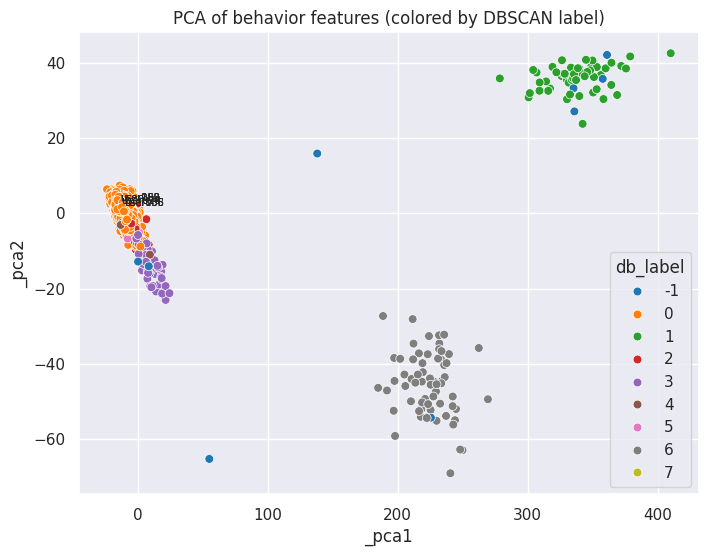

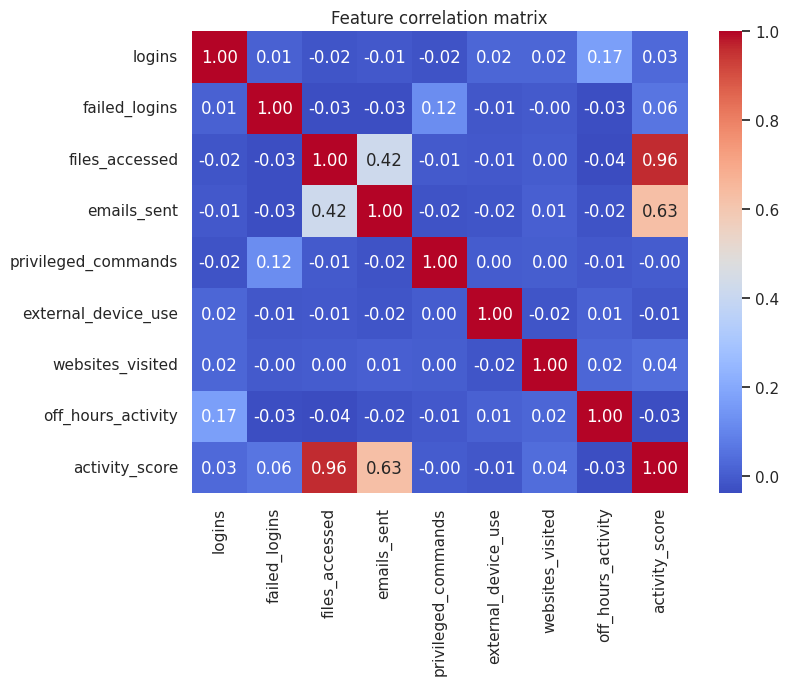

/tmp/ipython-input-3613001172.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




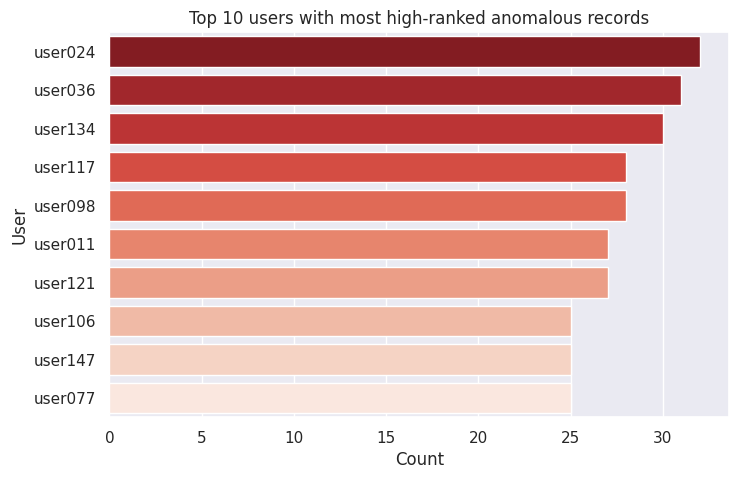

In [19]:

# Visualization - PCA scatter, correlation heatmap, top users bar chart
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_csv('/content/anomaly_results_v5.csv')
feature_cols = ['logins','failed_logins','files_accessed','emails_sent','privileged_commands','external_device_use','websites_visited','off_hours_activity','activity_score']

pca = PCA(n_components=2, random_state=1)
coords = pca.fit_transform(df[feature_cols].values)
df['_pca1'] = coords[:,0]; df['_pca2'] = coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='_pca1', y='_pca2', hue='db_label', palette='tab10', s=40)
top = df.sort_values('anom_rank', ascending=False).head(12)
for _, r in top.iterrows():
    plt.text(r['_pca1']+0.1, r['_pca2']+0.1, r['user'], fontsize=7)
plt.title('PCA of behavior features (colored by DBSCAN label)')
plt.show()

plt.figure(figsize=(8,6))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature correlation matrix')
plt.show()

top_users = df.sort_values('anom_rank', ascending=False)['user'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_users.values, y=top_users.index, palette='Reds_r')
plt.title('Top 10 users with most high-ranked anomalous records')
plt.xlabel('Count'); plt.ylabel('User')
plt.show()

Top anomalous records:
         user        date  anom_rank  logins  failed_logins  files_accessed  \
2266  user028  2025-08-04     3469.5       2              0               5   
3147  user074  2025-08-22     3469.5       2              0               5   
1644  user024  2025-09-06     3469.5       2              0               5   
1122  user153  2025-08-05     3421.0       1              0               5   
3001  user069  2025-08-26     3421.0       1              0               5   

      emails_sent  privileged_commands  external_device_use  websites_visited  \
2266            1                    0                    0                10   
3147            1                    0                    0                10   
1644            1                    0                    0                10   
1122            1                    0                    0                10   
3001            1                    0                    0                10   

      off_hours

/tmp/ipython-input-593282921.py:14: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



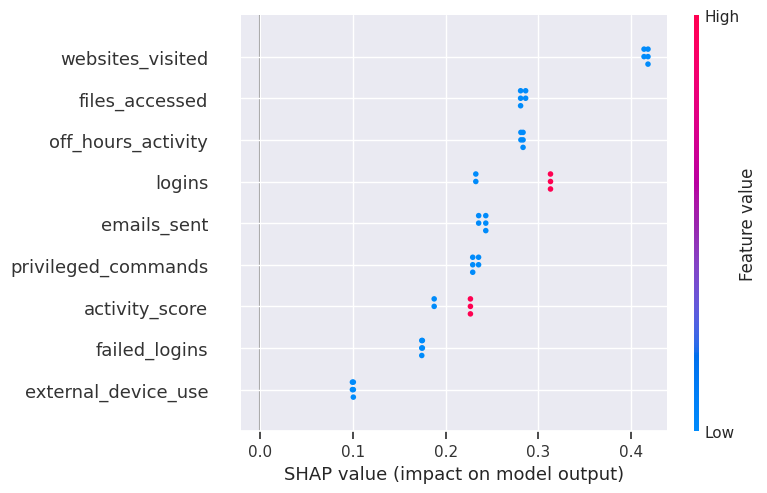

In [20]:

# SHAP explainability
import shap, pandas as pd
from sklearn.ensemble import IsolationForest
df = pd.read_csv('/content/anomaly_results_v5.csv')
feature_cols = ['logins','failed_logins','files_accessed','emails_sent','privileged_commands','external_device_use','websites_visited','off_hours_activity','activity_score']
X = df[feature_cols].values
iso2 = IsolationForest(n_estimators=200, contamination=0.10, random_state=0).fit(X)
explainer = shap.Explainer(iso2)
top_idx = df.sort_values('anom_rank', ascending=False).head(5).index
X_sample = df.loc[top_idx, feature_cols]
shap_values = explainer(X_sample)
print('Top anomalous records:')
print(df.loc[top_idx, ['user','date','anom_rank'] + feature_cols])
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=True)

In [21]:
# dashboard page
from google.colab import files
import IPython.display as disp

html_code = """<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Insider Threat Dashboard (Standalone)</title>
  <meta name="viewport" content="width=device-width,initial-scale=1">
  <!-- Plotly -->
  <script src="https://cdn.plot.ly/plotly-2.26.0.min.js"></script>
  <!-- PapaParse for CSV parsing -->
  <script src="https://cdn.jsdelivr.net/npm/papaparse@5.4.1/papaparse.min.js"></script>
  <!-- Simple styling -->
  <style>
    body { font-family: Arial, sans-serif; margin: 18px; background: #f7f9fc; color:#111; }
    h1 { margin-bottom: 6px; }
    .controls { margin: 12px 0 18px; display:flex; gap:12px; align-items:center; flex-wrap:wrap; }
    .card { background:white; padding:12px; border-radius:8px; box-shadow:0 1px 6px rgba(20,30,40,0.06); }
    #charts { display: grid; grid-template-columns: 1fr 1fr; gap: 14px; margin-top:12px; }
    #heatmap { grid-column: 1 / -1; height:420px; }
    .btn { padding:8px 12px; border-radius:6px; border:none; cursor:pointer; font-weight:600; }
    .btn-primary { background:#0b69ff; color:white; }
    .btn-ghost { background:transparent; border:1px solid #ddd; color:#333; }
    .small { font-size:13px; color:#444; }
    select, input[type=file] { padding:8px; border-radius:6px; border:1px solid #ccc; }
    #status { margin-left:8px; font-size:13px; color:#666; }
    @media (max-width:900px){ #charts{ grid-template-columns: 1fr; } #heatmap{ height:360px; } }
  </style>
</head>
<body>
  <div class="card">
    <h1>🛡️ Insider Threat Dashboard — Standalone</h1>
    <div class="small">Runs entirely in your browser. Upload the CSV from the Colab notebook (anomaly_results_v5.csv) or use sample data.</div>
  </div>

  <div class="controls">
    <label class="card">
      <input type="file" id="csvFile" accept=".csv">
      <span class="small"> Upload anomaly_results_v5.csv</span>
    </label>

    <button class="btn btn-ghost card" id="sampleBtn">Use sample data (demo)</button>

    <div class="card">
      <label class="small">Anomaly type</label><br>
      <select id="anomalyType">
        <option value="All">All Anomalies</option>
        <option value="HighFileAccess">High File Access</option>
        <option value="PrivilegeEscalation">Privilege Escalation</option>
        <option value="LateNight">Late-Night Activity</option>
        <option value="EmailExfiltration">Email Exfiltration</option>
      </select>
    </div>

    <div class="card">
      <label class="small">Top N users for bar chart</label><br>
      <input type="number" id="topN" value="10" min="3" max="50" style="width:80px;">
    </div>

    <div class="card">
      <button class="btn btn-primary" id="downloadBtn">Download filtered CSV</button>
      <span id="status"></span>
    </div>
  </div>

  <div id="charts">
    <div id="bar" class="card" style="padding:6px; height:380px;"></div>
    <div id="scatter" class="card" style="padding:6px; height:380px;"></div>
    <div id="heatmap" class="card"></div>
  </div>

<script>
// ---------- Utilities ----------
let rawData = null; // array of objects
let parsedDF = null;

function parseCSVFile(file) {
  document.getElementById('status').textContent = 'Parsing CSV...';
  Papa.parse(file, {
    header: true,
    dynamicTyping: true,
    skipEmptyLines: true,
    complete: function(results) {
      rawData = results.data;
      // normalize column names (trim)
      rawData = rawData.map(r => {
        const out = {};
        for (let k in r) out[k.trim()] = r[k];
        return out;
      });
      postProcessData();
      document.getElementById('status').textContent = 'CSV loaded: ' + rawData.length + ' rows';
      renderAll();
    },
    error: function(err){ alert('CSV parse error: ' + err.message); document.getElementById('status').textContent = 'Parse error'; }
  });
}

function downloadCSV(dataArray, filename='filtered_anomalies.csv') {
  const csv = Papa.unparse(dataArray);
  const blob = new Blob([csv], { type: 'text/csv;charset=utf-8;' });
  const link = document.createElement("a");
  const url = URL.createObjectURL(blob);
  link.setAttribute("href", url);
  link.setAttribute("download", filename);
  document.body.appendChild(link);
  link.click();
  document.body.removeChild(link);
  URL.revokeObjectURL(url);
}

// Convert date strings to Date object & ensure numeric columns exist
function postProcessData(){
  parsedDF = rawData.map(r => {
    const obj = Object.assign({}, r);
    // safe conversions
    obj.files_accessed = Number(obj.total_file_accesses ?? obj.files_accessed ?? 0) || 0;
    obj.emails_sent = Number(obj.emails_sent ?? 0) || 0;
    obj.privileged_commands = Number(obj.privileged_commands ?? obj.privileged_actions ?? 0) || 0;
    obj.off_hours_activity = Number(obj.off_hours_activity ?? obj.late_night ?? 0) || 0;
    obj.logins = Number(obj.logins ?? 0) || 0;
    obj.failed_logins = Number(obj.failed_logins ?? 0) || 0;
    obj.user = String(obj.user ?? obj.User ?? obj.username ?? 'unknown');
    // date parsing fallback
    obj.date = obj.date ? new Date(obj.date) : null;
    obj.weekday = obj.date ? ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'][obj.date.getDay()] : null;
    // compute activity_score if missing
    obj.activity_score = Number(obj.activity_score ?? (obj.files_accessed + obj.emails_sent*2 + (obj.websites_visited||0)*0.5 + obj.logins*1.5 + obj.failed_logins*2)) || 0;
    return obj;
  });
}

// ---------- Filtering logic ----------
function filterByAnomaly(type){
  if (!parsedDF) return [];
  const arr = parsedDF.slice();
  if (type === 'All') return arr;
  if (type === 'HighFileAccess'){
    // top 5% by files_accessed
    const cut = quantile(arr.map(d=>d.files_accessed).filter(v => v!=null), 0.95);
    return arr.filter(d => d.files_accessed >= cut);
  }
  if (type === 'PrivilegeEscalation'){
    return arr.filter(d => d.privileged_commands > 0);
  }
  if (type === 'LateNight'){
    return arr.filter(d => d.off_hours_activity === 1);
  }
  if (type === 'EmailExfiltration'){
    const cut = quantile(arr.map(d=>d.emails_sent).filter(v=>v!=null), 0.95);
    return arr.filter(d => d.emails_sent >= cut);
  }
  return arr;
}

function quantile(values, q){
  if (!values || values.length===0) return 0;
  const vs = values.slice().sort((a,b)=>a-b);
  const pos = (vs.length-1) * q;
  const base = Math.floor(pos);
  const rest = pos - base;
  if ((vs[base+1] !== undefined)) return vs[base] + rest * (vs[base+1]-vs[base]);
  return vs[base];
}

// ---------- Charts ----------
function renderBar(data){
  const topN = Number(document.getElementById('topN').value) || 10;
  // count per user
  const counts = {};
  data.forEach(d => counts[d.user] = (counts[d.user]||0)+1);
  const items = Object.keys(counts).map(k => ({user:k, count:counts[k]})).sort((a,b)=>b.count-a.count).slice(0, topN).reverse();
  const x = items.map(d=>d.count), y = items.map(d=>d.user);
  const trace = { x:x, y:y, type:'bar', orientation:'h', marker:{color:'#ff7f0e'} };
  const layout = { title:`Top ${topN} users with anomalies`, margin:{l:120} };
  Plotly.newPlot('bar', [trace], layout, {responsive:true});
}

function renderScatter(data){
  const x = data.map(d=>d.files_accessed), y = data.map(d=>d.emails_sent);
  const text = data.map(d => `${d.user}<br>${d.date?d.date.toISOString().slice(0,10):''}`);
  const color = data.map(d => d.privileged_commands || 0);
  const trace = { x:x, y:y, text:text, mode:'markers', marker:{size:10, color:color, colorscale:'Viridis', colorbar:{title:'privileged'}} };
  const layout = { title:'Files Accessed vs Emails Sent', xaxis:{title:'Files Accessed'}, yaxis:{title:'Emails Sent'}, margin:{t:40} };
  Plotly.newPlot('scatter', [trace], layout, {responsive:true});
}

function renderHeatmap(data){
  if (!data || data.length===0){ document.getElementById('heatmap').innerHTML = '<div class="small">No data for heatmap</div>'; return; }
  // pivot table: rows=user, cols=weekday sum(files_accessed)
  const grouped = {};
  data.forEach(d => {
    const u = d.user, w = d.weekday || 'Unknown';
    if (!grouped[u]) grouped[u] = {};
    grouped[u][w] = (grouped[u][w]||0) + (Number(d.files_accessed)||0);
  });
  // compute top users by total files
  const totals = Object.keys(grouped).map(u => ({user:u, total:Object.values(grouped[u]).reduce((a,b)=>a+b,0)}));
  totals.sort((a,b)=>b.total-a.total);
  const topUsers = totals.slice(0,10).map(t=>t.user);
  // weekdays order
  const days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'];
  const z = topUsers.map(u => days.map(day => grouped[u][day]||0));
  const trace = { z:z, x:days, y:topUsers, type:'heatmap', colorscale:'YlOrRd' };
  const layout = { title:'Weekly File Access Heatmap (Top 10 users)', height:420, margin:{l:120} };
  Plotly.newPlot('heatmap', [trace], layout, {responsive:true});
}

// ---------- UI wiring ----------
document.getElementById('csvFile').addEventListener('change', function(evt){
  const f = evt.target.files[0];
  if (!f) return;
  parseCSVFile(f);
});

document.getElementById('sampleBtn').addEventListener('click', function(){
  // generate small sample data for demo
  const users = Array.from({length:50}, (_,i)=>'user'+String(i+1).padStart(3,'0'));
  const rows = [];
  const start = new Date('2025-08-01');
  for (let i=0;i<500;i++){
    const user = users[Math.floor(Math.random()*users.length)];
    const date = new Date(start.getTime() + Math.floor(Math.random()*90)*24*3600*1000);
    const files = Math.max(0, Math.round(Math.random()*8 + (Math.random()<0.05?200*Math.random()+50:0)));
    const emails = Math.max(0, Math.round(Math.random()*3 + (Math.random()<0.03?30*Math.random()+10:0)));
    const priv = Math.random()<0.03?1:0;
    const off = Math.random()<0.05?1:0;
    rows.push({
      user: user, date: date.toISOString().slice(0,10), files_accessed: files,
      emails_sent: emails, privileged_commands: priv, off_hours_activity: off,
      logins: Math.max(1, Math.round(Math.random()*3)), failed_logins: Math.random()<0.05?Math.round(Math.random()*5):0
    });
  }
  rawData = rows.map(r => Object.assign({}, r));
  postProcessData();
  document.getElementById('status').textContent = 'Sample data loaded ('+rawData.length+' rows)';
  renderAll();
});

document.getElementById('anomalyType').addEventListener('change', renderAll);
document.getElementById('topN').addEventListener('input', renderAll);
document.getElementById('downloadBtn').addEventListener('click', function(){
  const type = document.getElementById('anomalyType').value;
  const filtered = filterByAnomaly(type);
  if (!filtered || filtered.length===0){ alert('No rows to download'); return; }
  downloadCSV(filtered, 'filtered_anomalies.csv');
});

function renderAll(){
  const type = document.getElementById('anomalyType').value;
  const filtered = filterByAnomaly(type);
  renderBar(filtered);
  renderScatter(filtered);
  renderHeatmap(filtered);
}

// initialize empty placeholders
Plotly.newPlot('bar', [{x:[0], y:['no data'], type:'bar'}], {margin:{l:120}});
Plotly.newPlot('scatter', [], {title:'Files vs Emails'});
document.getElementById('heatmap').innerHTML = '<div class="small">Upload CSV or use sample data to see heatmap</div>';
</script>
</body>
</html>
"""

file_path = "/content/insider_dashboard.html"
with open(file_path, "w", encoding="utf-8") as f:
    f.write(html_code)

print("insider_dashboard.html created at:", file_path)

disp.HTML(f'<a href="file_path" target="_blank">Click here to open the dashboard</a>')

files.download(file_path)


insider_dashboard.html created at: /content/insider_dashboard.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
files.download("/content/anomaly_results_v5.csv")
# to download the results file for the dashboard


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>